In [20]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [2]:
# load data
df = pd.read_csv('shortened_oil_data.csv')
df = df.dropna().copy()
print(df.shape)
df.head()

(1168, 468)


,Date,Brent_Oil,USD_CAD,Crude_Oil,DXY,Emerging_Mkt,Gold,Copper,Heating_Oil,Junk_Bond,...,US_Imp_Ethanol,US_Imp_JetFuel,US_Imp_Distillate,US_Imp_Distillate_LowS,US_Imp_Distillate_GT_MedS,US_Imp_Distillate_GT_500_to_2000_ppm_Sulfur,US_Imp_Distillate_GT_2000_ppm_Sulfur,US_Imp_Residual,US_Imp_Propane,US_Imp_Other
60,2021-03-31,63.540001,1.26208,59.160000,93.230003,48.142857,1713.800049,4.0030,1.7713,67.465019,...,0.0,248.0,441.0,441.0,0.0,0.0,0.0,194.0,148.0,710.0
61,2021-04-01,64.860001,1.25643,61.450001,92.930000,48.612198,1726.500000,4.0035,1.8316,67.607895,...,0.0,248.0,441.0,441.0,0.0,0.0,0.0,194.0,148.0,710.0
62,2021-04-05,62.150002,1.25640,58.650002,92.599998,48.801731,1727.000000,4.1490,1.7724,67.638954,...,0.0,93.0,325.0,293.0,0.0,32.0,0.0,34.0,133.0,673.0
63,2021-04-06,62.740002,1.25202,59.330002,92.339996,49.072506,1741.500000,4.1265,1.7941,67.755402,...,0.0,93.0,325.0,293.0,0.0,32.0,0.0,34.0,133.0,673.0
64,2021-04-07,63.160000,1.25714,59.770000,92.459999,48.350449,1740.099976,4.0640,1.8079,67.732132,...,0.0,93.0,325.0,293.0,0.0,32.0,0.0,34.0,133.0,673.0


In our dataset, we work with three major categories of features:
- **Fundamental** indicators (e.g., macroeconomic & supply–demand variables)
- **Technical** indicators derived from price series
- **EIA weekly** indicators

Because these feature groups differ substantially in their statistical structure and economic meaning, we apply PCA separately within each group rather than mixing all variables together. This allows us to:
- Preserve the internal structure of each feature class
- Extract interpretable low-dimensional factors
- Reduce noise and multicollinearity
- Avoid PCA being dominated by one category of features

In [28]:
# Define feature groups

# 1. fundamental features
fundamental_cols = df.columns[1:24]
fundamental_cols = [col for col in fundamental_cols if col != 'Crude_Oil']
print("Number of Fundamental features:", len(fundamental_cols))

# 2. technical features
# 2.1 momentum
mom_features = [
    'RSI_14', 'RSI_28', 
    'ROC_5', 'ROC_20', 
    'Ret_5d', 'Ret_20d', 'Ret_60d', 
    'Vol_Adj_Mom_20d', 'Vol_Adj_Mom_60d'
]
# 2.2 volatility
vol_features = [
    'BB_Width', 
    'Realized_Vol_20d', 'Realized_Vol_60d', 
    'Annual_Vol_20d', 
    'Price_Range_20d'
]
# Combine momentum and volatility features
mom_vol_features = mom_features + vol_features

print(f"Number of momentum features: {len(mom_features)}")
print(f"Number of volatility features: {len(vol_features)}")


# 3. EIA weekly features
eia_cols = df.columns[58:]
print("Number of EIA features:", len(eia_cols))

Number of Fundamental features: 22
Number of momentum features: 9
Number of volatility features: 5
Number of EIA features: 410


### 1. PCA for Fundamental Features
For the fundamental indicators, we include all available variables.

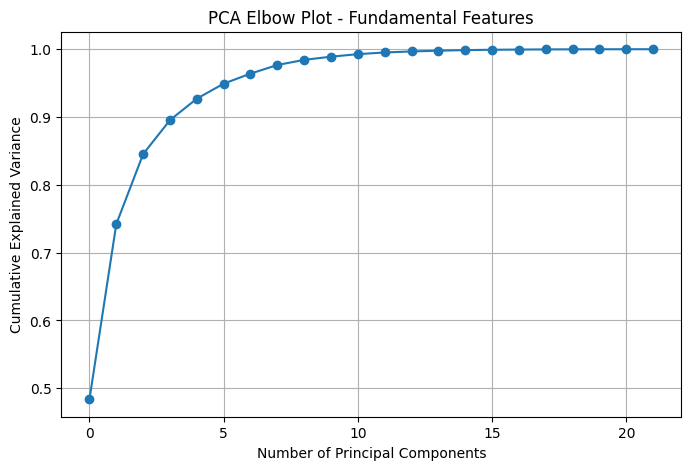

Fundamental PCA Loadings (first 5 PCs):


,PC1,PC2,PC3,PC4,PC5
Brent_Oil,-0.256706,0.047465,0.260960,-0.257454,-0.244721
USD_CAD,0.141218,0.333445,0.066645,0.266301,-0.045248
DXY,-0.094854,0.354399,0.080385,0.261666,-0.236429
Emerging_Mkt,0.229315,-0.235201,0.129185,-0.149582,0.044165
Gold,0.257973,0.095092,0.293474,0.096450,0.129256
Copper,0.200383,-0.133462,0.293353,-0.267516,0.136419
Heating_Oil,-0.245685,0.110843,0.304152,-0.040204,0.011141
Junk_Bond,0.289514,-0.006348,0.167032,-0.026750,-0.176552
Transportation,0.255884,-0.011349,0.087890,-0.288052,-0.387624
Natural_Gas,-0.172738,-0.114300,0.370491,0.294363,-0.144430


In [48]:
X_fund = df[fundamental_cols]
scaler = StandardScaler()
X_scaled_fund = scaler.fit_transform(X_fund)

# Fit Full PCA
pca_full_fund = PCA().fit(X_scaled_fund)

# Explained variance ratio
var_ratio = pca_full_fund.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

# Elbow Plot
plt.figure(figsize=(8,5))
plt.plot(cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Plot - Fundamental Features")
plt.grid(True)
plt.show()

k = 5   # 查看前5个PC
# PCA loadings = components_.T × sqrt(explained_variance_)
loadings_fund = pd.DataFrame(
    pca_full.components_[:k].T,
    index=fundamental_cols,
    columns=[f"PC{i+1}" for i in range(k)]
)

print("Fundamental PCA Loadings (first 5 PCs):")
display(loadings_fund)


### 2. PCA for Technical Indicators
Technical indicators differ from the other groups because they naturally decompose into different signal types.
Instead of applying PCA on all technical features together, we classify them into two economically meaningful subgroups:
- **Momentum** indicators (e.g., RSI, MACD-based signals)
- **Volatility** indicators (e.g., ATR, Bollinger Bands measures)  
For each subgroup, we select a set of representative and widely used indicators, and apply PCA separately.
This prevents overly heterogeneous signals from being mixed together and improves interpretability of the resulting components.
We also try applying PCA to the combined subgroups

#### 2.1 Momentum

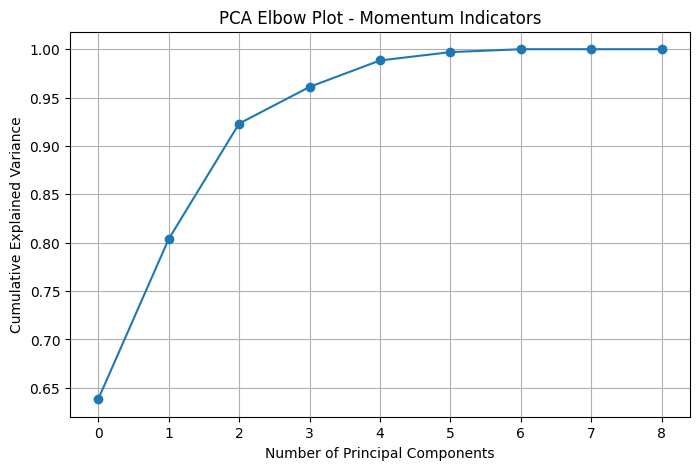

In [30]:
X_mom = df[mom_features]

scaler_mom = StandardScaler()
X_mom_scaled = scaler_mom.fit_transform(X_mom)

pca_mom = PCA()
X_mom_vol_pca = pca_mom.fit_transform(X_mom_scaled)

var_ratio = pca_mom.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

plt.figure(figsize=(8,5))
plt.plot(cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Plot - Momentum Indicators")
plt.grid(True)
plt.show()

#### 2.1 Volatility

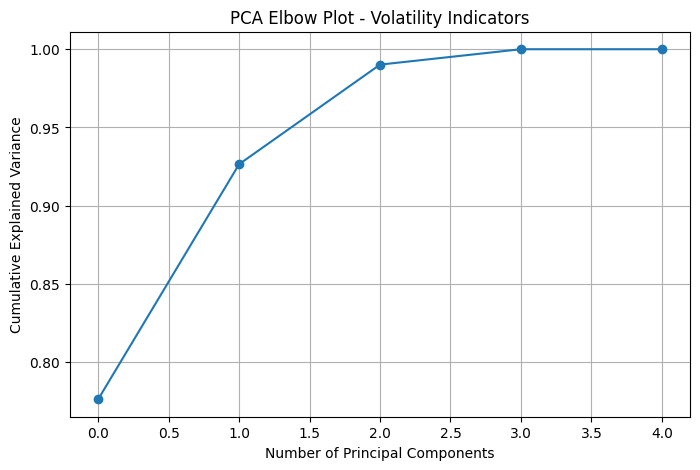

In [31]:
X_vol = df[vol_features]

scaler_vol = StandardScaler()
X_vol_scaled = scaler_vol.fit_transform(X_vol)

pca_vol = PCA()
X_vol_pca = pca_vol.fit_transform(X_vol_scaled)

var_ratio = pca_vol.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

plt.figure(figsize=(8,5))
plt.plot(cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Plot - Volatility Indicators")
plt.grid(True)
plt.show()

#### Momentum + Volatility

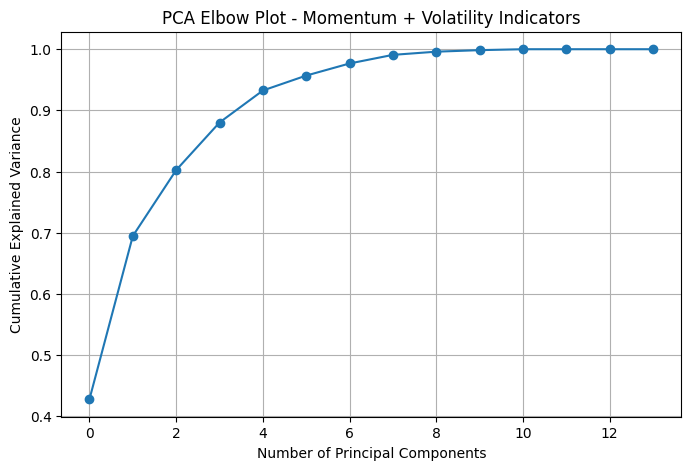

In [32]:
X_mom_vol = df[mom_vol_features]

scaler_mom_vol = StandardScaler()
X_mom_vol_scaled = scaler_mom_vol.fit_transform(X_mom_vol)

pca_mom_vol = PCA()
X_mom_vol_pca = pca_mom_vol.fit_transform(X_mom_vol_scaled)

var_ratio = pca_mom_vol.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

plt.figure(figsize=(8,5))
plt.plot(cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Plot - Momentum + Volatility Indicators")
plt.grid(True)
plt.show()

#### *Principal Component Loading Analysis*
View the contribution of each feature to the principal components

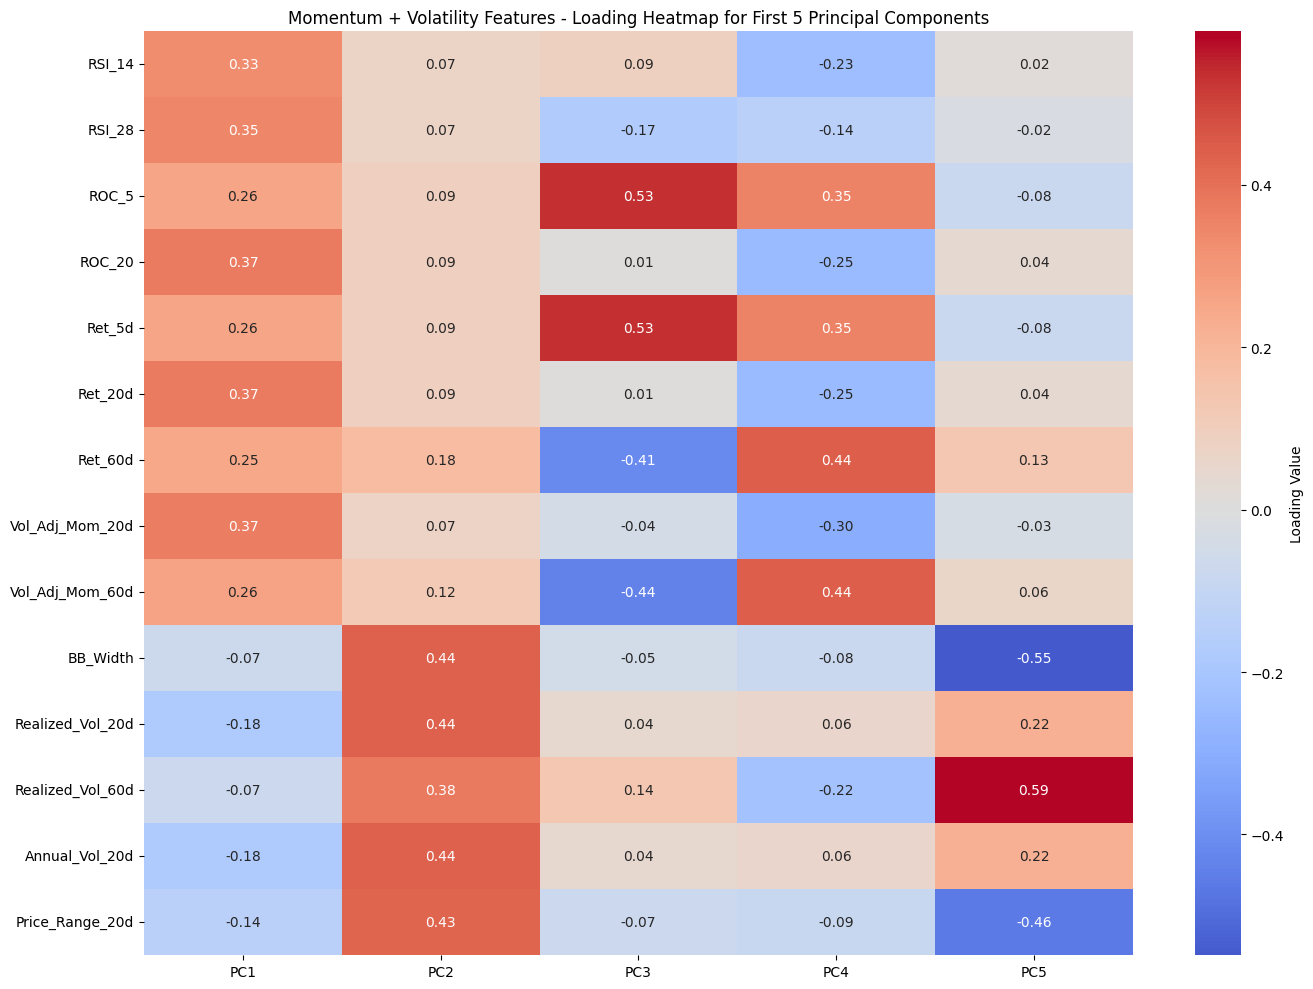

In [34]:
# Principal component loadings for combined features
loadings_mom_vol = pd.DataFrame(
    pca_mom_vol.components_.T,
    columns=[f'PC{i+1}' for i in range(len(mom_vol_features))],
    index=mom_vol_features
)
# Visualize loadings for first 5 principal components
plt.figure(figsize=(14, 10))
sns.heatmap(loadings_mom_vol.iloc[:, :5], annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', cbar_kws={'label': 'Loading Value'})
plt.title('Momentum + Volatility Features - Loading Heatmap for First 5 Principal Components')
plt.tight_layout()
plt.show()

##### *Comparative Analysis: Combined PCA vs Separate PCA for technical indicators*
Compare results of performing PCA on combined features vs separate features

In [33]:
print(f"\nMomentum Features PCA - PC1 Explained Variance Ratio: {pca_mom.explained_variance_ratio_[0]:.4f} ({pca_mom.explained_variance_ratio_[0]*100:.2f}%)")
print(f"Volatility Features PCA - PC1 Explained Variance Ratio: {pca_vol.explained_variance_ratio_[0]:.4f} ({pca_vol.explained_variance_ratio_[0]*100:.2f}%)")

print(f"\nCombined Features PCA - PC1 Explained Variance Ratio: {pca_mom_vol.explained_variance_ratio_[0]:.4f} ({pca_mom_vol.explained_variance_ratio_[0]*100:.2f}%)")
print(f"Combined Features PCA - PC2 Explained Variance Ratio: {pca_mom_vol.explained_variance_ratio_[1]:.4f} ({pca_mom_vol.explained_variance_ratio_[1]*100:.2f}%)")


Momentum Features PCA - PC1 Explained Variance Ratio: 0.6382 (63.82%)
Volatility Features PCA - PC1 Explained Variance Ratio: 0.7763 (77.63%)

Combined Features PCA - PC1 Explained Variance Ratio: 0.4277 (42.77%)
Combined Features PCA - PC2 Explained Variance Ratio: 0.2669 (26.69%)


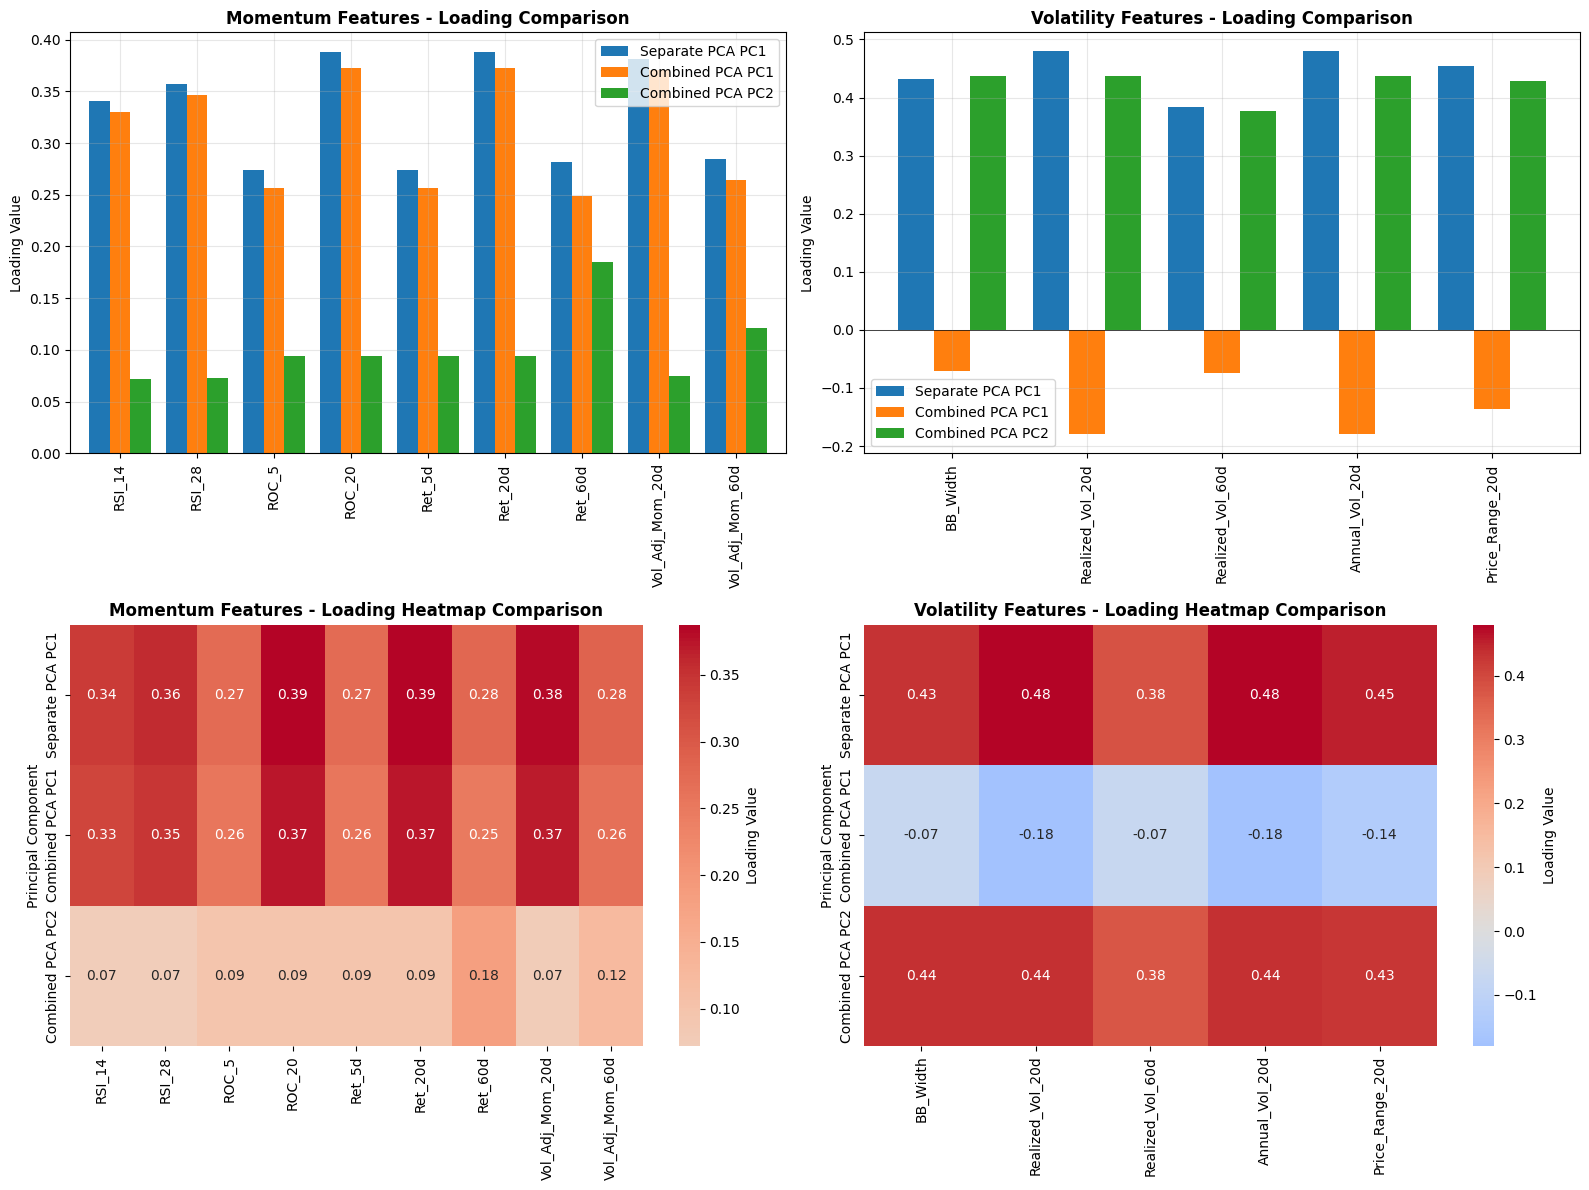

<Figure size 640x480 with 0 Axes>

In [40]:
# Visualize loading comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Momentum features: Separate PC1 vs Combined PC1
mom_comparison = pd.DataFrame({
    'Separate PCA PC1': pca_mom.components_[0, :],
    'Combined PCA PC1': pca_mom_vol.components_[0, :len(mom_features)],
    'Combined PCA PC2': pca_mom_vol.components_[1, :len(mom_features)]
}, index=mom_features)

mom_comparison.plot(kind='bar', ax=axes[0, 0], width=0.8)
axes[0, 0].set_title('Momentum Features - Loading Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loading Value')
axes[0, 0].legend(loc='best')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# 2. Volatility features: Separate PC1 vs Combined PC1
vol_comparison = pd.DataFrame({
    'Separate PCA PC1': pca_vol.components_[0, :],
    'Combined PCA PC1': pca_mom_vol.components_[0, len(mom_features):],
    'Combined PCA PC2': pca_mom_vol.components_[1, len(mom_features):]
}, index=vol_features)

vol_comparison.plot(kind='bar', ax=axes[0, 1], width=0.8)
axes[0, 1].set_title('Volatility Features - Loading Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loading Value')
axes[0, 1].legend(loc='best')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# 3. Momentum features heatmap comparison
sns.heatmap(mom_comparison.T, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[1, 0], cbar_kws={'label': 'Loading Value'})
axes[1, 0].set_title('Momentum Features - Loading Heatmap Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Principal Component')

# 4. Volatility features heatmap comparison
sns.heatmap(vol_comparison.T, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[1, 1], cbar_kws={'label': 'Loading Value'})
axes[1, 1].set_title('Volatility Features - Loading Heatmap Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Principal Component')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [41]:
# Calculate similarity between loading vectors (cosine similarity)
from scipy.spatial.distance import cosine

print("Loading Vector Similarity Analysis (Cosine Similarity)")


# Momentum features: Separate PC1 vs Combined PC1
mom_sep_pc1 = pca_mom.components_[0, :]
mom_comb_pc1 = pca_mom_vol.components_[0, :len(mom_features)]
mom_comb_pc2 = pca_mom_vol.components_[1, :len(mom_features)]

sim_mom_pc1_comb_pc1 = 1 - cosine(mom_sep_pc1, mom_comb_pc1)
sim_mom_pc1_comb_pc2 = 1 - cosine(mom_sep_pc1, mom_comb_pc2)

print(f"\nMomentum Features:")
print(f"  Separate PCA-PC1 vs Combined PCA-PC1: {sim_mom_pc1_comb_pc1:.4f} (Similarity: {abs(sim_mom_pc1_comb_pc1):.4f})")
print(f"  Separate PCA-PC1 vs Combined PCA-PC2: {sim_mom_pc1_comb_pc2:.4f} (Similarity: {abs(sim_mom_pc1_comb_pc2):.4f})")

# Volatility features: Separate PC1 vs Combined PC1
vol_sep_pc1 = pca_vol.components_[0, :]
vol_comb_pc1 = pca_mom_vol.components_[0, len(mom_features):]
vol_comb_pc2 = pca_mom_vol.components_[1, len(mom_features):]

sim_vol_pc1_comb_pc1 = 1 - cosine(vol_sep_pc1, vol_comb_pc1)
sim_vol_pc1_comb_pc2 = 1 - cosine(vol_sep_pc1, vol_comb_pc2)

print(f"\nVolatility Features:")
print(f"  Separate PCA-PC1 vs Combined PCA-PC1: {sim_vol_pc1_comb_pc1:.4f} (Similarity: {abs(sim_vol_pc1_comb_pc1):.4f})")
print(f"  Separate PCA-PC1 vs Combined PCA-PC2: {sim_vol_pc1_comb_pc2:.4f} (Similarity: {abs(sim_vol_pc1_comb_pc2):.4f})")

print(f"\nExplanation:")
print(f"  - Cosine similarity close to 1 or -1 indicates very similar loading patterns (direction may be reversed)")
print(f"  - Cosine similarity close to 0 indicates uncorrelated loading patterns")
print(f"  - Larger absolute values indicate more similar meanings")

Loading Vector Similarity Analysis (Cosine Similarity)

Momentum Features:
  Separate PCA-PC1 vs Combined PCA-PC1: 0.9997 (Similarity: 0.9997)
  Separate PCA-PC1 vs Combined PCA-PC2: 0.9166 (Similarity: 0.9166)

Volatility Features:
  Separate PCA-PC1 vs Combined PCA-PC1: -0.9573 (Similarity: 0.9573)
  Separate PCA-PC1 vs Combined PCA-PC2: 0.9991 (Similarity: 0.9991)

Explanation:
  - Cosine similarity close to 1 or -1 indicates very similar loading patterns (direction may be reversed)
  - Cosine similarity close to 0 indicates uncorrelated loading patterns
  - Larger absolute values indicate more similar meanings


### *Comparative Conclusion*

Based on the analysis above, we can derive:

In [42]:
# Summarize comparative results
print("=" * 70)
print("Comparative Analysis Summary")
print("=" * 70)

print("\n1. Explained Variance Ratio Comparison:")
print(f"   - Momentum Features Separate PCA-PC1: {pca_mom.explained_variance_ratio_[0]*100:.2f}%")
print(f"   - Volatility Features Separate PCA-PC1: {pca_vol.explained_variance_ratio_[0]*100:.2f}%")
print(f"   - Combined Features PCA-PC1: {pca_mom_vol.explained_variance_ratio_[0]*100:.2f}%")
print(f"   - Combined Features PCA-PC2: {pca_mom_vol.explained_variance_ratio_[1]*100:.2f}%")

print("\n2. Loading Similarity:")
print(f"   Momentum Features:")
print(f"     - Separate PC1 vs Combined PC1 Similarity: {abs(sim_mom_pc1_comb_pc1):.4f} {'(Very Similar)' if abs(sim_mom_pc1_comb_pc1) > 0.8 else '(Similar)' if abs(sim_mom_pc1_comb_pc1) > 0.5 else '(Not Very Similar)'}")
print(f"     - Separate PC1 vs Combined PC2 Similarity: {abs(sim_mom_pc1_comb_pc2):.4f} {'(Very Similar)' if abs(sim_mom_pc1_comb_pc2) > 0.8 else '(Similar)' if abs(sim_mom_pc1_comb_pc2) > 0.5 else '(Not Very Similar)'}")
print(f"   Volatility Features:")
print(f"     - Separate PC1 vs Combined PC1 Similarity: {abs(sim_vol_pc1_comb_pc1):.4f} {'(Very Similar)' if abs(sim_vol_pc1_comb_pc1) > 0.8 else '(Similar)' if abs(sim_vol_pc1_comb_pc1) > 0.5 else '(Not Very Similar)'}")
print(f"     - Separate PC1 vs Combined PC2 Similarity: {abs(sim_vol_pc1_comb_pc2):.4f} {'(Very Similar)' if abs(sim_vol_pc1_comb_pc2) > 0.8 else '(Similar)' if abs(sim_vol_pc1_comb_pc2) > 0.5 else '(Not Very Similar)'}")

print("\n3. Conclusion:")
if abs(sim_mom_pc1_comb_pc1) > 0.7 and abs(sim_vol_pc1_comb_pc1) > 0.7:
    print("   ✓ Combined PCA PC1 has similar meaning to separate PCA PC1 for both feature groups")
    print("   ✓ Combined PCA may capture the overall main variation patterns")
elif abs(sim_mom_pc1_comb_pc1) > 0.7 or abs(sim_vol_pc1_comb_pc1) > 0.7:
    print("   ⚠ Combined PCA PC1 mainly reflects main variation from one feature group")
    print("   ⚠ Information from the other feature group may be in PC2 or subsequent principal components")
else:
    print("   ⚠ Combined PCA produces different principal component structure")
    print("   ⚠ Recommend checking which features are captured by PC1 and PC2 separately")

if abs(sim_mom_pc1_comb_pc2) > 0.7:
    print("   • Momentum features' main information is captured by combined PCA PC2")
if abs(sim_vol_pc1_comb_pc2) > 0.7:
    print("   • Volatility features' main information is captured by combined PCA PC2")

Comparative Analysis Summary

1. Explained Variance Ratio Comparison:
   - Momentum Features Separate PCA-PC1: 63.82%
   - Volatility Features Separate PCA-PC1: 77.63%
   - Combined Features PCA-PC1: 42.77%
   - Combined Features PCA-PC2: 26.69%

2. Loading Similarity:
   Momentum Features:
     - Separate PC1 vs Combined PC1 Similarity: 0.9997 (Very Similar)
     - Separate PC1 vs Combined PC2 Similarity: 0.9166 (Very Similar)
   Volatility Features:
     - Separate PC1 vs Combined PC1 Similarity: 0.9573 (Very Similar)
     - Separate PC1 vs Combined PC2 Similarity: 0.9991 (Very Similar)

3. Conclusion:
   ✓ Combined PCA PC1 has similar meaning to separate PCA PC1 for both feature groups
   ✓ Combined PCA may capture the overall main variation patterns
   • Momentum features' main information is captured by combined PCA PC2
   • Volatility features' main information is captured by combined PCA PC2


### 3. PCA for EIA Indicators
For the EIA weekly features, we include all indicators in the PCA procedure.
EIA data are typically high-dimensional and contain many related measures (inventories, production, refinery utilization, imports/exports, etc.). PCA helps compress these signals into a smaller set of components that capture the main supply–demand dynamics.

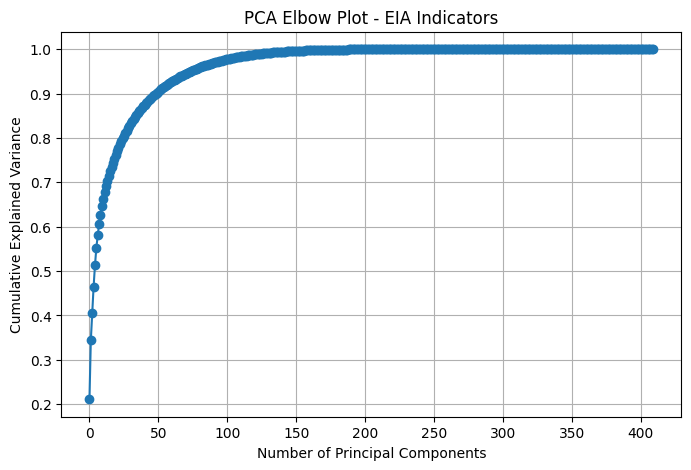

In [43]:
X_eia = df[eia_cols]
scaler = StandardScaler()
X_scaled_eia = scaler.fit_transform(X_eia)

# Full PCA for elbow plot
pca_full_eia = PCA().fit(X_scaled_eia)

var_ratio = pca_full_eia.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

plt.figure(figsize=(8,5))
plt.plot(cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Plot - EIA Indicators")
plt.grid(True)
plt.show()


## Create Dimensionality-Reduced Features

Select principal components that retain a certain proportion of variance

In [49]:
# === Fundamental PCs ===
fund_PC = pca_full_fund.transform(X_scaled_fund)[:, :3]
df_PC_fund = pd.DataFrame(
    fund_PC,
    columns=[f"Fund_PC{i+1}" for i in range(3)],
    index=df.index
)

# === Technical PCs ===
tech_PC = pca_mom_vol.transform(X_mom_vol_scaled)[:, :2]
df_PC_tech = pd.DataFrame(
    tech_PC,
    columns=[f"Tech_PC{i+1}" for i in range(2)],
    index=df.index
)

# === EIA PCs ===
eia_PC = pca_full_eia.transform(X_scaled_eia)[:, :5]
df_PC_eia = pd.DataFrame(
    eia_PC,
    columns=[f"EIA_PC{i+1}" for i in range(5)],
    index=df.index
)

# Combine PC features
df_PC_all = pd.concat([df_PC_fund, df_PC_tech, df_PC_eia], axis=1)

# Add to the front of dataset
df_final = pd.concat([df_PC_all, df], axis=1)

df_final.head()


,Fund_PC1,Fund_PC2,Fund_PC3,Tech_PC1,Tech_PC2,EIA_PC1,EIA_PC2,EIA_PC3,EIA_PC4,EIA_PC5,...,US_Imp_Ethanol,US_Imp_JetFuel,US_Imp_Distillate,US_Imp_Distillate_LowS,US_Imp_Distillate_GT_MedS,US_Imp_Distillate_GT_500_to_2000_ppm_Sulfur,US_Imp_Distillate_GT_2000_ppm_Sulfur,US_Imp_Residual,US_Imp_Propane,US_Imp_Other
60,0.855723,-4.101164,-2.650218,-1.045459,1.937045,-24.848521,-4.289029,-12.200222,-0.867363,0.509192,...,0.0,248.0,441.0,441.0,0.0,0.0,0.0,194.0,148.0,710.0
61,0.772281,-4.037837,-2.650612,-0.094932,2.166130,-24.848521,-4.289029,-12.200222,-0.867363,0.509192,...,0.0,248.0,441.0,441.0,0.0,0.0,0.0,194.0,148.0,710.0
62,1.250798,-4.197912,-2.638924,-2.339323,1.555255,-23.186945,-1.990317,-11.398270,-0.830468,4.697815,...,0.0,93.0,325.0,293.0,0.0,32.0,0.0,34.0,133.0,673.0
63,1.153908,-4.301649,-2.615880,-1.994787,1.647617,-23.186945,-1.990317,-11.398270,-0.830468,4.697815,...,0.0,93.0,325.0,293.0,0.0,32.0,0.0,34.0,133.0,673.0
64,1.054958,-4.190836,-2.703672,-1.548460,1.727264,-23.186945,-1.990317,-11.398270,-0.830468,4.697815,...,0.0,93.0,325.0,293.0,0.0,32.0,0.0,34.0,133.0,673.0


## Summary

PCA analysis completed, dimensionality-reduced features can be used for subsequent modeling

In [50]:
# Save final dataset to CSV
output_path = "pca_oil_data.csv"
df_final.to_csv(output_path, index=False)

print(f"Saved PCA-augmented dataset to: {output_path}")

Saved PCA-augmented dataset to: pca_oil_data.csv


In [52]:
print("=" * 60)
print("PCA Summary")
print("=" * 60)

print(f"\n1. Fundamental Features:")
print(f"   - Original number of features: {len(fundamental_cols)}")
print(f"   - Number of principal components retained: 3")
print(f"   - Explained variance ratio: {pca_full_fund.explained_variance_ratio_[:3].sum():.4f} ({pca_full_fund.explained_variance_ratio_[:3].sum()*100:.2f}%)")

print(f"\n2. Technical Indicators (Momentum + Volatility):")
print(f"   - Original number of features: {len(mom_vol_features)}")
print(f"   - Number of principal components retained: 2")
print(f"   - Explained variance ratio: {pca_mom_vol.explained_variance_ratio_[:2].sum():.4f} ({pca_mom_vol.explained_variance_ratio_[:2].sum()*100:.2f}%)")

print(f"\n3. EIA Indicators:")
print(f"   - Original number of features: {len(eia_cols)}")
print(f"   - Number of principal components retained: 5")
print(f"   - Explained variance ratio: {pca_full_eia.explained_variance_ratio_[:5].sum():.4f} ({pca_full_eia.explained_variance_ratio_[:5].sum()*100:.2f}%)")

print(f"\nTotal Dimensionality Reduction:")
print(f"   - Original total features: {len(fundamental_cols) + len(mom_vol_features) + len(eia_cols)}")
print(f"   - PCA-reduced features: 3 + 2 + 5 = 10")
print(f"   - Reduction ratio: {(1 - 10/(len(fundamental_cols) + len(mom_vol_features) + len(eia_cols)))*100:.1f}%")

PCA Summary

1. Fundamental Features:
   - Original number of features: 22
   - Number of principal components retained: 3
   - Explained variance ratio: 0.8453 (84.53%)

2. Technical Indicators (Momentum + Volatility):
   - Original number of features: 14
   - Number of principal components retained: 2
   - Explained variance ratio: 0.6946 (69.46%)

3. EIA Indicators:
   - Original number of features: 410
   - Number of principal components retained: 5
   - Explained variance ratio: 0.5129 (51.29%)

Total Dimensionality Reduction:
   - Original total features: 446
   - PCA-reduced features: 3 + 2 + 5 = 10
   - Reduction ratio: 97.8%
